# Initialization

Test notebook for the C-MAPPS benchmark. Approach using MLP. 

First we import the necessary packages and create the global variables.

In [44]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import time

import CMAPSAuxFunctions
#import plottingTools
#from datetime import datetime
#from sklearn.covariance import EllipticEnvelope
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.mplot3d import Axes3D
#from dataManagement import DataManagerDamadics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from IPython.display import display, HTML
%matplotlib notebook

global constRUL

constRUL = 125
time_window = 30
rul_vector = None

CMAPSAuxFunctions.set_const_RUL(constRUL)

# Retrieve and Reshape data

Get the data from the text files, store it in a Pandas Dataframe and reshape it as appropiately.

In [45]:
data_file_train = '../CMAPSSData/train_FD001.txt'
data_file_test = '../CMAPSSData/test_FD001.txt'

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardScaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

nFeatures = len(selected_features)

#Get the X and y matrices with the specified time window
X_train, y_train = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, time_window, 'train')
X_test, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'test')
y_test = np.loadtxt("../CMAPSSData/RUL_FD001.txt")
y_test = np.array([x if x < constRUL else constRUL for x in y_test])
y_test = np.reshape(y_test, (y_test.shape[0], 1))

#Standardize the data
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

In [46]:
print("Training data")
print(X_train.shape)
print(y_train.shape)
print("Testing data")
print(X_test.shape)
print(y_test.shape)
print("Training data")
print(X_train[-5:,:])
print(y_train[-5:,:])
print("Testing data")
print(X_test[-5:,:])
print(y_test[-5:,:])

Training data
(17731, 420)
(17731, 1)
Testing data
(100, 420)
(100, 1)
Training data
[[ 0.62199313  0.32071611  0.36067504 ...  0.45454545 -0.4488189
  -0.77474791]
 [ 0.20962199  0.14475703  0.60204082 ...  0.09090909 -0.7480315
  -0.24669791]
 [ 0.12714777  0.14475703  0.71428571 ...  0.63636364 -0.52755906
  -0.88893623]
 [ 0.03092784  0.14475703  0.78296703 ...  0.09090909 -0.76377953
  -0.51768215]
 [ 0.26460481  0.15191816  0.50039246 ...  0.27272727 -0.63779528
  -0.55120011]]
[[4.]
 [3.]
 [2.]
 [1.]
 [0.]]
Testing data
[[-0.72682927 -0.95827124 -0.89279113 ... -0.71428571  0.45238095
   0.84135021]
 [ 0.13170732 -0.44336811 -0.39149723 ...  0.42857143 -0.38095238
   0.14388186]
 [-0.08292683 -0.01266766 -0.3323475  ...  0.14285714 -0.02380952
   0.42025316]
 [-0.49268293 -0.23919523 -0.92310536 ... -0.71428571  0.42857143
   0.41476793]
 [-0.32682927 -0.11698957  0.06617375 ...  0.71428571 -0.16666667
  -0.31940928]]
[[125.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


# Keras model

We will use a very simple ANN for this example. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [57]:
def RULmodel(input_shape):
    
    print(input_shape)
    
    #Create a sequential model
    model = Sequential()
    
    #Add the layers for the model
    model.add(Dense(500, input_dim=input_shape, activation='tanh', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='tanh', kernel_initializer='glorot_normal', name='fc2'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='tanh', name='fc3'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='tanh', name='fc4'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', name='out'))
    
    #create a placeholder for the input
    #X_input = Input(shape=(input_shape))
    
    #Create the layers
    #X = Dense(100, activation='relu', name='fc1')(X_input)
    #X = Dense(100, activation='relu', name='fc2')(X)
    #X = Dense(1, activation='linear', name='out')(X)
    
    # Create model. This creates the Keras model instance, you'll use this instance to train/test the model.
    #model = Sequential(inputs = X_input, outputs = X, name='RUL')
    
    return model

# Fit the keras model
Fit the Keras model to the data and determine its performance.

In [70]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)
opt = Adam(lr=0, beta_1=0.5)

#Create the model
modelRUL = RULmodel(X_train.shape[1])

#Compile the model.
modelRUL.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRUL.fit(x = X_train, y = y_train, epochs = 250, batch_size = 512, callbacks=[lrate])  
endTime = time.clock()

420
Epoch 1/250
17731/17731 [==============================] - 0s 15us/step - loss: 6411.7903 - mean_squared_error: 6411.7903
Epoch 2/250
17731/17731 [==============================] - 0s 9us/step - loss: 5662.8130 - mean_squared_error: 5662.8130
Epoch 3/250
17731/17731 [==============================] - 0s 9us/step - loss: 5218.7550 - mean_squared_error: 5218.7550
Epoch 4/250
17731/17731 [==============================] - 0s 9us/step - loss: 4813.9412 - mean_squared_error: 4813.9412
Epoch 5/250
17731/17731 [==============================] - 0s 9us/step - loss: 4445.6333 - mean_squared_error: 4445.6333
Epoch 6/250
17731/17731 [==============================] - 0s 9us/step - loss: 4109.2804 - mean_squared_error: 4109.2804
Epoch 7/250
17731/17731 [==============================] - 0s 10us/step - loss: 3797.2276 - mean_squared_error: 3797.2276
Epoch 8/250
17731/17731 [==============================] - 0s 9us/step - loss: 3516.4000 - mean_squared_error: 3516.4000
Epoch 9/250
17731/17731 [=

17731/17731 [==============================] - 0s 9us/step - loss: 250.5785 - mean_squared_error: 250.5785
Epoch 136/250
17731/17731 [==============================] - 0s 9us/step - loss: 244.7967 - mean_squared_error: 244.7967
Epoch 137/250
17731/17731 [==============================] - 0s 9us/step - loss: 239.5596 - mean_squared_error: 239.5596
Epoch 138/250
17731/17731 [==============================] - 0s 10us/step - loss: 237.7399 - mean_squared_error: 237.7399
Epoch 139/250
17731/17731 [==============================] - 0s 11us/step - loss: 245.7771 - mean_squared_error: 245.7771
Epoch 140/250
17731/17731 [==============================] - 0s 12us/step - loss: 242.6803 - mean_squared_error: 242.6803
Epoch 141/250
17731/17731 [==============================] - 0s 9us/step - loss: 243.9941 - mean_squared_error: 243.9941
Epoch 142/250
17731/17731 [==============================] - 0s 9us/step - loss: 241.2952 - mean_squared_error: 241.2952
Epoch 143/250
17731/17731 [================

In [71]:
#Evaluate the model
score = modelRUL.evaluate(x = X_test, y = y_test)
y_pred = modelRUL.predict(X_test)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 892us/step
Root Square Mean Error score: 17.39401808328907
Health score: [570.13265086]
Elapsed time: 41.87684618689673


# CNN Model
Fit the Keras model to the data using a CNN and determine its performance.

# Initialization

In [60]:
import os, math, random, pickle, time
import numpy as np
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers.pooling import AveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, Input, merge, Conv2D, Reshape, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
import keras
from sklearn import preprocessing
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import CMAPSAuxFunctions

# Constants

In [61]:
FeatureN = 14
nb_epoch = 250
batch_size = 512
FilterN = 10
FilterL = 10
rmse,sco,tm = [], [], []

ConstRUL = 125
TW = 30
Dataset = '1'

# Reshape data to fit a convNet

In [62]:
samples = np.reshape(X_train, newshape=(X_train.shape[0], int(X_train.shape[1]/nFeatures), nFeatures))
samplet = np.reshape(X_test, newshape=(X_test.shape[0], int(X_test.shape[1]/nFeatures), nFeatures))
targets = y_train
labelt = y_test
print("Training data")
print(samples.shape)
print(targets.shape)
print("Testing data")
print(samplet.shape)
print(labelt.shape)
print("Training data")
print(samples[-5:,:])
print(targets[-5:])
print("Testing data")
print(samplet[-5:,:])
print(labelt[-5:])

Training data
(17731, 30, 14)
(17731, 1)
Testing data
(100, 30, 14)
(100, 1)
Training data
[[[ 0.62199313  0.32071611  0.36067504 ...  0.6        -0.51851852
   -0.17989737]
  [ 0.19322034  0.14475703  0.60204082 ...  0.4        -0.51851852
   -0.07425294]
  [ 0.11186441  0.14475703  0.71428571 ...  0.4        -0.33333333
   -0.21430727]
  ...
  [ 0.52583587  0.14453891  0.60540348 ... -0.09090909 -0.62790698
   -0.33108677]
  [ 0.3253012   0.26444299  0.76501955 ... -0.09090909 -1.
   -0.1628756 ]
  [ 0.37349398  0.17462394  0.5658339  ...  0.45454545 -0.4488189
   -0.77474791]]

 [[ 0.20962199  0.14475703  0.60204082 ...  0.4        -0.51851852
   -0.07425294]
  [ 0.11186441  0.14475703  0.71428571 ...  0.4        -0.33333333
   -0.21430727]
  [ 0.01694915  0.14475703  0.78296703 ...  0.2        -0.48148148
   -0.39480833]
  ...
  [ 0.33738602  0.26444299  0.76501955 ... -0.09090909 -1.
   -0.1628756 ]
  [ 0.37349398  0.17462394  0.64877355 ...  0.45454545 -0.4488189
   -0.77730974]


# Keras model

CNN model. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [63]:
def RULCNNModel(TW, FeatureN):
    
    input_layer = Input(shape=(TW, FeatureN))
    y = Reshape((TW, FeatureN, 1), input_shape=(TW, FeatureN, ),name = 'Reshape')(input_layer)

    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C1')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C2')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C3')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C4')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C5')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C6')(y)
    
    y = Conv2D(1, 3, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='Clast')(y)  
    
    y = Reshape((TW,14))(y)
    y = Flatten()(y)
    y = Dropout(0.5)(y)
    
    #y = Dense(100, activation='tanh', init='glorot_normal', activity_regularizer=keras.regularizers.l2(0.01),)(y)
    y = Dense(100,activation='tanh', kernel_initializer='glorot_normal', name='fc')(y)
    y = Dense(1)(y)
    
    model = Model(inputs = input_layer, outputs = y, name='RUL_CNN_Model')
    
    return model

# Fit the keras model

Fit the Keras model to the data and determine its performance.

In [64]:
opt = Adam(lr=0, beta_1=0.5)
#DCNN = Model([input_layer], [y])
DCNN = RULCNNModel(TW, FeatureN)
#DCNN.compile(loss=get_score,optimizer=opt)
DCNN.compile(loss='mean_squared_error',optimizer=opt)
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)


startTime = time.clock()
history = DCNN.fit(samples, targets,nb_epoch=nb_epoch, batch_size=batch_size,verbose=1, 
                   validation_data=(samplet, labelt), callbacks=[lrate])
endTime = time.clock()

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C1", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C2", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  import sys
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C3", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C4", kernel_initializer="glorot_normal", paddi

Train on 17731 samples, validate on 100 samples
Epoch 1/250
17731/17731 [==============================] - 1s 32us/step - loss: 6706.5176 - val_loss: 5142.6948
Epoch 2/250
17731/17731 [==============================] - 0s 21us/step - loss: 5794.5055 - val_loss: 4729.3071
Epoch 3/250
17731/17731 [==============================] - 0s 21us/step - loss: 5335.3949 - val_loss: 4364.4805
Epoch 4/250
17731/17731 [==============================] - 0s 22us/step - loss: 4924.0684 - val_loss: 4033.6741
Epoch 5/250
17731/17731 [==============================] - 0s 21us/step - loss: 4547.8229 - val_loss: 3674.4343
Epoch 6/250
17731/17731 [==============================] - 0s 22us/step - loss: 4201.2942 - val_loss: 3380.4087
Epoch 7/250
17731/17731 [==============================] - 0s 22us/step - loss: 3881.8215 - val_loss: 3146.0220
Epoch 8/250
17731/17731 [==============================] - 0s 22us/step - loss: 3585.8987 - val_loss: 2829.3013
Epoch 9/250
17731/17731 [==============================]

17731/17731 [==============================] - 0s 22us/step - loss: 188.7629 - val_loss: 357.6118
Epoch 75/250
17731/17731 [==============================] - 0s 22us/step - loss: 188.9735 - val_loss: 222.3662
Epoch 76/250
17731/17731 [==============================] - 0s 22us/step - loss: 182.0741 - val_loss: 255.5368
Epoch 77/250
17731/17731 [==============================] - 0s 21us/step - loss: 184.7357 - val_loss: 257.6741
Epoch 78/250
17731/17731 [==============================] - 0s 22us/step - loss: 178.4292 - val_loss: 235.0886
Epoch 79/250
17731/17731 [==============================] - 0s 21us/step - loss: 184.9516 - val_loss: 209.6402
Epoch 80/250
17731/17731 [==============================] - 0s 22us/step - loss: 179.6979 - val_loss: 265.8133
Epoch 81/250
17731/17731 [==============================] - 0s 21us/step - loss: 176.7809 - val_loss: 238.5089
Epoch 82/250
17731/17731 [==============================] - 0s 21us/step - loss: 178.3345 - val_loss: 225.0562
Epoch 83/250
1

17731/17731 [==============================] - 0s 22us/step - loss: 123.0191 - val_loss: 224.0745
Epoch 221/250
17731/17731 [==============================] - 0s 22us/step - loss: 124.6488 - val_loss: 224.6901
Epoch 222/250
17731/17731 [==============================] - 0s 22us/step - loss: 124.0988 - val_loss: 229.5419
Epoch 223/250
17731/17731 [==============================] - 0s 22us/step - loss: 125.1301 - val_loss: 227.6479
Epoch 224/250
17731/17731 [==============================] - 0s 22us/step - loss: 123.6621 - val_loss: 220.7322
Epoch 225/250
17731/17731 [==============================] - 0s 22us/step - loss: 123.6425 - val_loss: 222.6944
Epoch 226/250
17731/17731 [==============================] - 0s 22us/step - loss: 122.4883 - val_loss: 231.3876
Epoch 227/250
17731/17731 [==============================] - 0s 22us/step - loss: 123.9108 - val_loss: 231.1671
Epoch 228/250
17731/17731 [==============================] - 0s 22us/step - loss: 123.2311 - val_loss: 226.8380
Epoch 

In [65]:
#Evaluate the model
score = DCNN.evaluate(samplet, labelt)
y_pred = DCNN.predict(samplet)
healtScore = CMAPSAuxFunctions.compute_health_score(labelt, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score)))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 120us/step
Root Square Mean Error score: 15.01020072970528
Health score: [302.40498103]
Elapsed time: 96.8936980594226


<IPython.core.display.Javascript object>


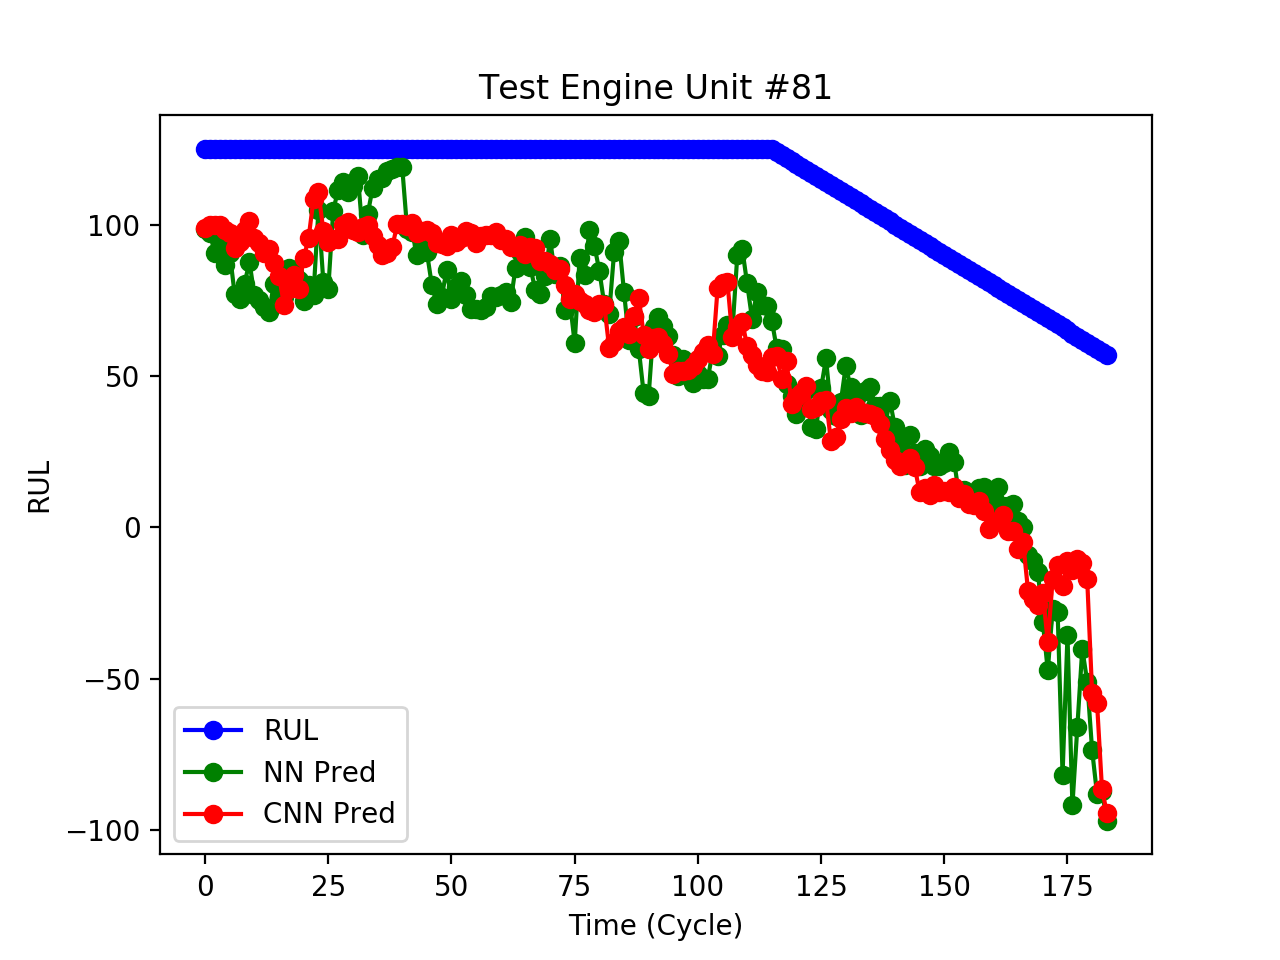

In [72]:
engineUnit = 81

X_test2, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'train', unit_Number=engineUnit)
X_test2 = min_max_scaler.fit_transform(X_test2)

samplet2 = np.reshape(X_test2, newshape=(X_test2.shape[0], int(X_test2.shape[1]/nFeatures), nFeatures))

nnPred = modelRUL.predict(X_test2)
cnnPred = DCNN.predict(samplet2)

maxCycle = X_test2.shape[0]
faultCycle = y_test[unit-1]
cycles = np.arange(maxCycle)
rulArray = np.arange(faultCycle, maxCycle+faultCycle)
rulArray[rulArray > constRUL] = constRUL
rulArray = np.flipud(rulArray)

#print(cycles)
#print(rulArray)

'''print("Testing data")
print(X_test2.shape)
print(X_test2[-5:,:])
print(nnPred)
print(cnnPred)'''

plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit)

In [41]:
def plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    plt.plot(cycles, cnnPred, 'ro-', label='CNN Pred')
    plt.legend()
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    plt.show()